# Seismic inversion of real data

This notebook aims at presenting a simple example of relative seismic inversion. 

Kerry3D data is used for demonstation as it is publicly available.

- Data is read from SEG-Y file using segyio 
- Relative seismic inversion is applied by means of pylops.avo.poststack.PoststackInversion 
- Inverted data is saved back to SEG-Y file using segyio

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio
import pylops

## Loading the data

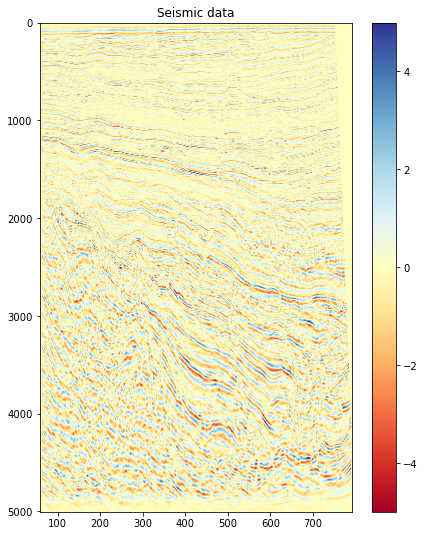

In [2]:
segyfile = './Kerry3D.segy'

f = segyio.open(segyfile, iline=segyio.tracefield.TraceField.SourceEnergyDirectionExponent, 
                xline=segyio.tracefield.TraceField.CDP)

il, xl, t = f.ilines, f.xlines, f.samples
dt = t[1] - t[0]

d = segyio.cube(f)
nil, nxl, nt = d.shape

plt.figure(figsize=(7, 9))
plt.imshow(d[nil//2].T, cmap='RdYlBu', vmin=-5, vmax=5,
           extent=(xl[0], xl[-1], t[-1], t[0]))
plt.title('Seismic data')
plt.colorbar()
plt.axis('tight')

In [5]:
t_wav = np.arange(nt_wav) * (dt/1000)
-t_wav[0:5]

array([-0.   , -0.004, -0.008, -0.012, -0.016])

## Estimating wavelet using  simple *statistical wavelet* estimation in frequency domain.

Text(0.5, 1.0, 'Time')

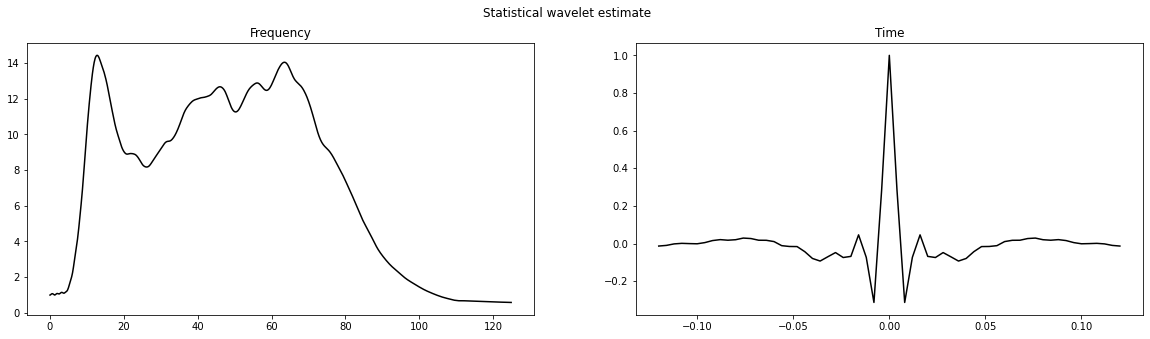

In [6]:
nt_wav = 31 # lenght of wavelet in samples
nfft = 2**11 # lenght of fft

# time axis for wavelet
t_wav = np.arange(nt_wav) * (dt/1000) 
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(d[..., :100], nfft, axis=-1)), axis=(0, 1))
fwest = np.fft.fftfreq(nfft, d=dt/1000)

# create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()
wcenter = np.argmax(np.abs(wav_est))

# display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(t_wav, wav_est, 'k')
axs[1].set_title('Time')

Let's perform now the inversion

In [5]:
# swap time axis to first dimension
d_small = d[..., :500]
d_small = np.swapaxes(d_small, -1, 0)

m_relative, r_relative = \
    pylops.avo.poststack.PoststackInversion(d_small, wav_est, m0=np.zeros_like(d_small), explicit=True, epsI=1e-4,
                                            simultaneous=False)
m_relative_reg, r_relative_reg = \
    pylops.avo.poststack.PoststackInversion(d_small, wav_est, m0=m_relative, epsI=1e-4, epsR=1e0, 
                                            **dict(iter_lim=10, show=2))
# swap time axis back to last dimension
d_small = np.swapaxes(d_small, 0, -1)
m_relative = np.swapaxes(m_relative, 0, -1)
m_relative_reg = np.swapaxes(m_relative_reg, 0, -1)
r_relative = np.swapaxes(r_relative, 0, -1)
r_relative_reg = np.swapaxes(r_relative_reg, 0, -1)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 2.10945e+08 rows  and 1.05472e+08 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.184e+04  2.184e+04    1.0e+00  1.9e-04
     1  0.00000e+00   1.453e+04  1.453e+04    6.7e-01  6.2e-01   5.6e+00  1.0e+00
     2  0.00000e+00   1.065e+04  1.065e+04    4.9e-01  3.4e-01   8.2e+00  2.3e+00
     3  0.00000e+00   8.750e+03  8.750e+03    4.0e-01  2.3e-01   1.0e+01  3.8e+00
     4  0.00000e+00   7.556e+03  7.556e+03    3.5e-01  1.8e-01   1.1e+01  5.4e+00
     5  0.00000e+00   6.756e+03  6.756e+03    3.1e-01  1.4e-01   1.3e+01  7.2e+00
     6  0.00000e+00   6.231e+03  6.231e+03    2.9e-01  1.1e-01   1.4e+01  9.1e+00
     7  0.00000e+00   5.851e+03  5.851e+03    2.7e-01  8.9e-02   1.5e+01  1.1e+01
     8  0.00000e+00   

## comparing the results

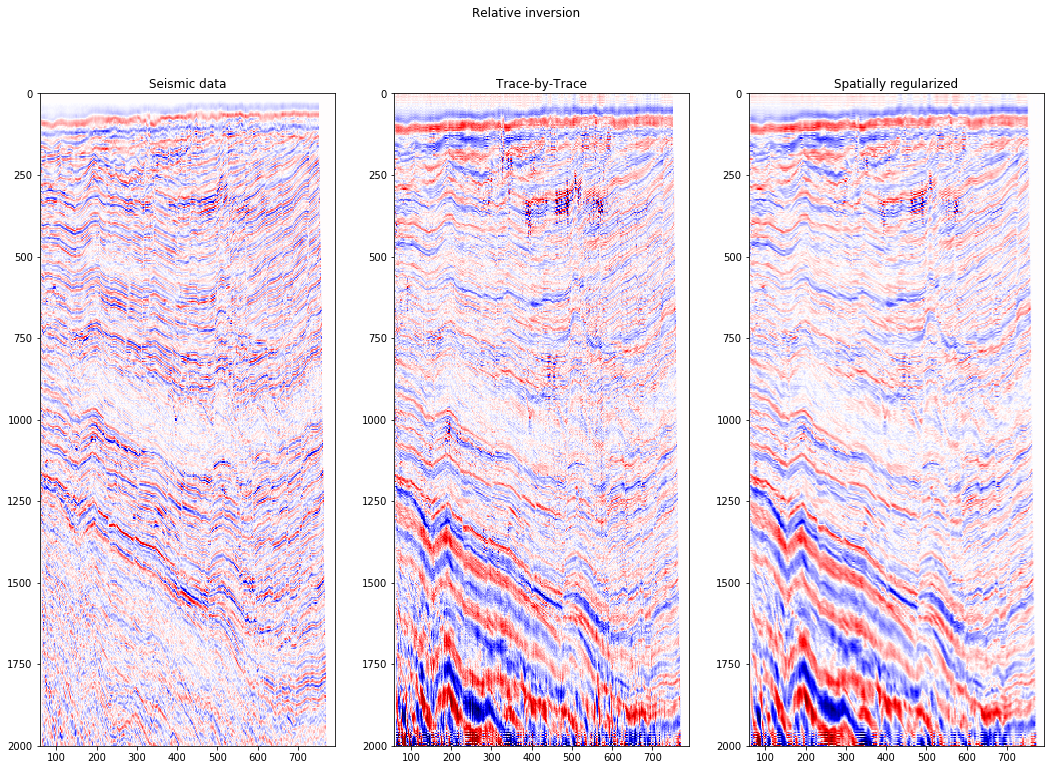

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 12))
fig.suptitle('Relative inversion')
axs[0].imshow(d_small[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(m_relative[nil//2].T, cmap='seismic', vmin=-0.2*m_relative.max(), vmax=0.2*m_relative.max(),
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')
axs[2].imshow(m_relative_reg[nil//2].T, cmap='seismic', vmin=-0.2*m_relative.max(), vmax=0.2*m_relative.max(),
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

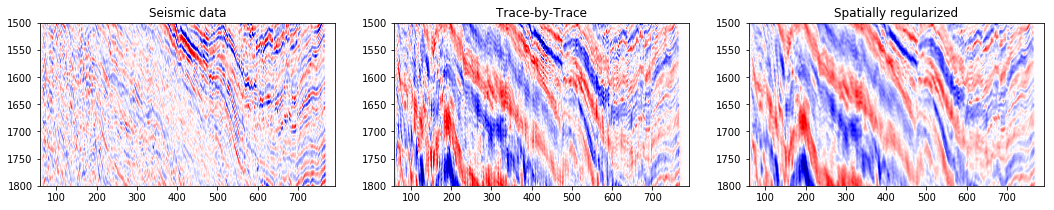

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3))
axs[0].imshow(d_small[nil//2].T, cmap='seismic', interpolation='sinc', vmin=-10, vmax=10,
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[0].set_ylim(1800, 1500)
axs[1].imshow(m_relative[nil//2].T, cmap='seismic', interpolation='sinc', 
              vmin=-0.2*m_relative.max(), vmax=0.2*m_relative.max(),
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')
axs[1].set_ylim(1800, 1500)
axs[2].imshow(m_relative_reg[nil//2].T, cmap='seismic', interpolation='sinc', 
              vmin=-0.2*m_relative.max(), vmax=0.2*m_relative.max(),
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight')
axs[2].set_ylim(1800, 1500);

### Adding  a time slice

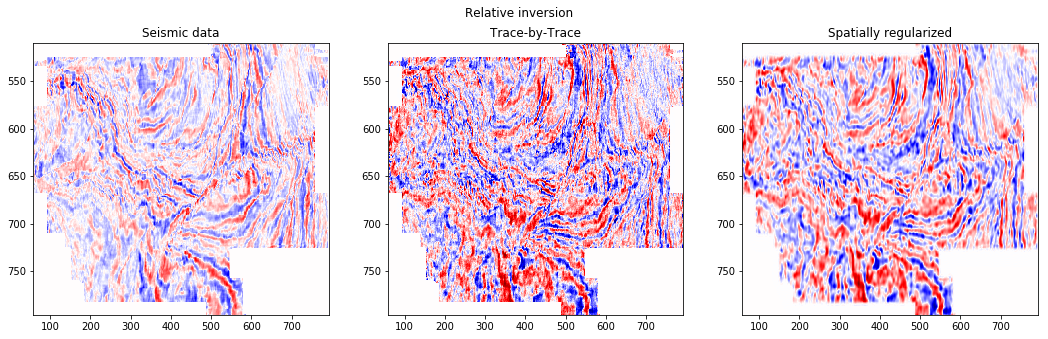

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Relative inversion')
axs[0].imshow(d_small[...,200], cmap='seismic', vmin=-10, vmax=10,
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight');
axs[1].imshow(m_relative[...,200], cmap='seismic', vmin=-0.1*m_relative.max(), vmax=0.1*m_relative.max(),
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight');
axs[2].imshow(m_relative_reg[...,200], cmap='seismic', vmin=-0.1*m_relative.max(), vmax=0.1*m_relative.max(),
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

## Displaying the residuals

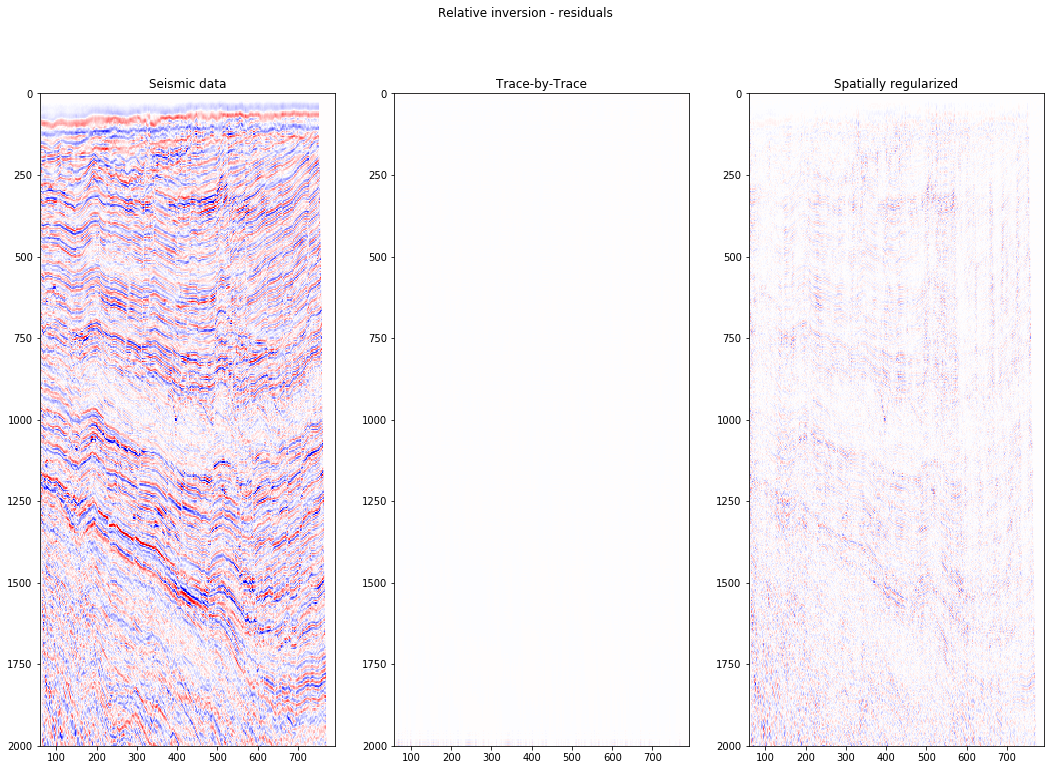

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(18, 12))
fig.suptitle('Relative inversion - residuals')
axs[0].imshow(d_small[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(r_relative[nil//2].T, cmap='seismic', vmin=-10, vmax=10, 
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')
axs[2].imshow(r_relative_reg[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xl[0], xl[-1], t[500], t[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

# Saving the inverted seismic file

In [10]:
segyfile_inverted = '../data/Kerry3D_inverted.segy'

with segyio.open(segyfile, iline=segyio.tracefield.TraceField.SourceEnergyDirectionExponent, 
                 xline=segyio.tracefield.TraceField.CDP) as src:
        spec = segyio.spec()
        spec.sorting = int(src.sorting)
        spec.format = int(src.format)
        spec.samples = t[:500]
        spec.ilines = src.ilines
        spec.xlines = src.xlines

        with segyio.create(segyfile_inverted, spec) as dst:
            # Copy all textual headers, including possible extended
            for i in range(src.ext_headers):
                dst.text[i] = src.text[i]

            # Copy the binary header, then insert the modifications needed for the new time axis
            dst.bin = src.bin
            dst.bin = {segyio.BinField.Samples: 500}
            
            # Copy all trace headers to destination file
            dst.header.iline = src.header.iline
            
            # Modify headers to have IL and XL at more standard bytes
            tr = 0
            for il in spec.ilines:
                for xl in spec.xlines:
                    dst.header[tr] = {
                        segyio.tracefield.TraceField.INLINE_3D : il,
                        segyio.tracefield.TraceField.CROSSLINE_3D : xl,
                        segyio.TraceField.TRACE_SAMPLE_COUNT: 500} 
                    tr +=1

            # Copy data
            for iil, iline in enumerate(dst.ilines):
                dst.iline[iline] = m_relative[iil].astype('float32')

### check

In [11]:
m_saved = segyio.cube(segyfile_inverted)

np.allclose(m_relative, m_saved)

True